# 17. Parameter fitting on _A. nidulans_ data

## Numerical experiments - Week 21/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Based on the more abundant, time-based data from the _A. niger_ experiments, the most successful models from the previous fitting procedure are used to explain germination data from experiments on _A. nidulans_ conidia [1].

## Prerequisite libraries

In [2]:
using PyPlot
using JLD2
using Statistics
using Distributions
using Revise
using Printf

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
Revise.includet("./germstats.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils
using .GermStats

## 1. Fitting considerations

The _A. nidulans_ dataset does not contain values from which time-dependent evolutions can be reconstructed. Nonetheless, it is noted the measurements are taken at 11 hours of incubation. An alternative study [2] state that the half-saturation time $\tau_g$ for germ tube formation in _A. nidulans_ in a comparable medium is 9.67 hours, the germination rate saturation is 85.46% and the respective design parameter $\nu$ is 6.28. The spore density used in this study is $2.7\times10^5$ spores/mL - at this density, the 11-hour germination rate aligned with the measurements by Herrero-Garcia is estimated to be about 80% [1].

The conflicting findings in the two experiments are rooted in the fact that the 11-hour measurement time in Herrero-Garcia et al [1] is closer to the half-saturation time in the alternative study [2] rather than to a full saturation time. This could suggest that the Dantigny parameters for the data in Herrero-Garcia et al. are different from those in Ijadpanahsaravi et al, likely due to differences in the strain and the cultivation medium used. On the other hand, Herrero-Garcia et al. do not explicitly specify the method used to classify conidia as germinated, which could imply that the percentages also include swollen spores. In any case, it is plausible to assume that the indicated density-dependent germination rates are equilibrium values, i.e. they would not increase significantly under a continued experiment.

With this in consideration, the fitting procedure is required to use **equilibrium probabilities** only. The 5 models chosen for this are
- inducer-dependent inhibitor threshold and release;
- 2-factor germination with inhibitor-dependent induction threshold;
- 2-factor germination with inhibitor-dependent induction signal;
- 2-factor germination with inhibitor-dependent induction threshold and signal;
- independent 2-factor germination with varying permeability.

All models may incorporate a slowly permeating carbon signal, but this assumption becomes irrelevant in the equilibrium limit.

## 2. Equilibrium probabilities

### 2.1. Inducer-dependent inhibitor threshold and release

The time-dependent probability in the first model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \pi_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\pi{(\pi_{\textrm{eff}})}\ f_\xi{(\xi)}\ d{\pi_{\textrm{eff}}}}\ d{\xi}}.
\end{equation}
$$

It was previously shown that, in the equilibrium limit, $\beta=\phi$, so the distribution of $\pi_{\textrm{eff}}$, along with its integral, becomes obsolete. Therefore, the new probability takes the form

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

This is a simple integral which can be solved without resorting to Gauss-Hermite approximation.

If an exogenous concentration of inhibitor is considered upon inoculation, the equilibrium limit of the residual inhibitor concentration in the spore becomes

$$
\begin{equation}
c_{\textrm{in}}^{\textrm{eq}}=\phi \psi+(1-\phi)c_{\textrm{ex}}.
\end{equation}
$$

With the condition for inhibitor depletion,

$$
\begin{equation}
\phi \psi+(1-\phi)c_{\textrm{ex}}<\gamma \psi,
\end{equation}
$$

the germination probability can be formulated as

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}+(1-\phi)\frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\psi{(\psi)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\xi}}.
\end{equation}
$$

### 2.2. Two-factor germination with inhibitor-dependent induction threshold

The time-dependent probability in the second model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right] f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

It was previously shown that, in the equilibrium limit, $\beta=\phi$, hence the equilibrium value of $c_{\textrm{in}}^{\textrm{eq}}=\phi\psi$. Since $c_{\textrm{in}}\to 0$ and $\phi$ is only dependent on $\xi$, the integral over $\psi$ can be omitted. In the long-time limit, the carbon source concentration at the receptor proteins equalises to the ambient concentration in the medium, $c_{\textrm{out}}^{\textrm{cs}}$, so the integral over $\kappa$ can be discarded. Thus, the equilibrium signal strength becomes

$$
\begin{equation}
s_{\textrm{eq}}=\frac{c_{\textrm{out}}^{\textrm{cs}}}{c_{\textrm{out}}^{\textrm{cs}}+K_{\textrm{cs}}}.
\end{equation}
$$

Taking this together, the germination probability simplifies to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s_{\textrm{eq}}-k\phi{(\xi)}\psi-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right]f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

In summary, the residual inhibition still affects both the inhibition-determined germination trigger and the threshold of the inducing signal.

Considering the exogenous inhibitor, the probability is reformulated to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}+(1-\phi)\frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\Phi{\left(\frac{s_{\textrm{eq}}-k\left[\phi{(\xi)}\psi+(1-\phi)c_{\textrm{ex}}\right]-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}f_\xi{(\xi)}\ d{\psi}}\ d{\xi}}.
\end{equation}
$$

### 2.3. Two-factor germination with inhibitor-dependent induction signal

In the third model, the inhibitor concentration reaches an equilibrium in its effect on the signal strength:

$$
\begin{equation}
s_{\textrm{eq}}'=s_{\textrm{eq}}\left[1+\left(\frac{\phi{(\xi)\psi}}{K_I}\right)^n\right]^{-1}.
\end{equation}
$$

This results in the equilibrium probability

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s_{\textrm{eq}}\left[1+\left(\frac{\phi{(\xi)\psi}}{K_I}\right)^n\right]^{-1}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right]f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

Considering the exogenous inhibitor, the probability is reformulated to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}+(1-\phi)\frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\Phi{\left(\frac{s_{\textrm{eq}}\left[1+\left(\frac{\phi{(\xi)\psi}}{K_I}\right)^n\right]^{-1}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}f_\xi{(\xi)}\ d{\psi}}\ d{\xi}}.
\end{equation}
$$

### 2.4. Two-factor germination with inhibitor-dependent induction threshold and signal

Combining the last two models yields

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s_{\textrm{eq}}\left[1+\left(\frac{\phi{(\xi)\psi}}{K_I}\right)^n\right]^{-1}-k\phi{(\xi)}\psi-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right]f_\xi{(\xi)}\ d{\xi}}
\end{equation}
$$

and, in the case of an exogenous inhibitor,

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}+(1-\phi)\frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\Phi{\left(\frac{s_{\textrm{eq}}\left[1+\left(\frac{\phi{(\xi)\psi}}{K_I}\right)^n\right]^{-1}-k\left[\phi{(\xi)}\psi+(1-\phi)c_{\textrm{ex}}\right]-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}f_\xi{(\xi)}\ d{\psi}}\ d{\xi}}.
\end{equation}
$$

### 2.5. Independent two-factor germination with with varying permeability

The time-dependent probability in the last model follows the expression

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)}\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\alpha{(\alpha)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)\ d{\alpha}}}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

Since $\beta=\phi$ and $\phi$ is only dependent on $\xi$, the integral over $\alpha$ can be omitted. Similarly, in the long-time limit, the carbon source concentration at the receptor proteins equalises to the ambient concentration in the medium, $c_{\textrm{out}}^{\textrm{cs}}$, making the computations with $t$ and $\kappa$ obsolete. Thus, the germination probability simplifies to

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\Phi{\left(\frac{s_{\textrm{eq}}-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\xi{(\xi)}\ d{\xi}}.
\end{equation}
$$

It should be noted that this probability does not involve any information about the distribution of the permeation constant or the cell wall porosity, so it is identical with the case of a deterministic permeation constant. Since this is a simple integral, it does not require a Gauss-Hermite approximation.

Taking into account the exogenous inhibitor concentration, the germination probability becomes

$$
\begin{equation}
p_{\textrm{eq}}(\textrm{germination})=\Phi{\left(\frac{s_{\textrm{eq}}-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}+(1-\phi)\frac{c_{\textrm{ex}}}{\psi}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\psi{(\psi)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\xi}}.
\end{equation}
$$

## 3. Data and default parameters

The germination data and the corresponding densities are stored in variables below. The parameter boundaries remain as in the previous parameter fitting procedure. The spore diameters are reported to vary from 2.4 to 2.7 [3], which is interpreted as a 95% confidence interval. This means that the distribution parameters of the spore radii can be set to $\mu_\xi=1.275\ \mu\textrm{m}$ and $\sigma_\xi=0.0375\ \mu\textrm{m}$ [3].

The external concentration of the carbon source can be computed by considering that the study uses a minimal medium (MMA) as described in Pontecorvo et al. [4]. The carbon source used in this medium is dextrose, of which $10\ \textrm{g}$ are dilluted in 1 liter of water. Having a molar mass of $180\ \textrm{g/mol}$, the dextrose has a concentration of $10\ \textrm{g}/(180\ \textrm{g/mol}\times 1\ \textrm{L})\approx0.0556\ \textrm{M}$.

It is known that _A. nidulans_ germinates up to 50% even in the absence of a carbon source [2]. Capturing this in a negative induction threshold, it implies that $p{(\omega)<0}=0$. This is always true for a Gaussian distribution, so there is effectively no upper boundary for the coefficient of variation of $\omega$. On the other hand, a control experiment without forced inhibition exhibits 95% germination success [1], so the 5% negative threshold assumption from the previous fitting procedure is maintained.

In [2]:
# Germination data
densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
germ_responses = [0.913, 0.925, 0.83, 0.72, 0.17, 0.08]
conf_intervals = [0.071, 0.074, 0.07, 0.061, 0.003, 0.003]

density_ex = 1e5
ex_concentrations = [1.0, 2.5, 4.0, 5.0] .* 0.001
germ_responses_ex = [0.87, 0.36, 0.14, 0.01]
conf_intervals_ex = [0.061, 0.043, 0.021, 0.003]

# Define default parameters globally
def_params = Dict(
    :μ_ξ => 1.275,
    :σ_ξ => 0.0703755,
    :c₀_cs => 0.00556
)

# Define parameter bounds globally
bounds_narrow = Dict(
    :k => (-6, 6),
    :K_cs => (1e-8, 0.1),
    :K_I => (1e-5, 1.0),
    :n => (1.0, 3.0),
    :μ_γ => (1e-6, 1e-4),
    :δ_γ => (-10, 10),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, 0),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0)
)

bounds_broad = Dict(
    :k => (-6, 6),
    :K_cs => (1e-8, 10.0),
    :K_I => (1e-5, 1.0),
    :n => (1.0, 3.0),
    :μ_γ => (1e-8, 1e-1),
    :δ_γ => (-10, 10),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, 0),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0)
)

# Radius distribution
μ_ξ = def_params[:μ_ξ]
σ_ξ = def_params[:σ_ξ]
μ_ξ_log = log(μ_ξ^2 / sqrt(σ_ξ^2 + μ_ξ^2))
σ_ξ_log = sqrt(log(σ_ξ^2 / μ_ξ^2 + 1))
dist_ξ = LogNormal(μ_ξ_log, σ_ξ_log)

LogNormal{Float64}(μ=0.24142516924483823, σ=0.05515449873856522)

## 4. Fitting to density-dependent data

For specific models, the parameters fitted in the previous optimisation step are tested with the current inputs to observe the germination response. Then a new parameter estimation is performed on the data set.

### 4.1. Inducer-dependent inhibitor threshold and release

In [3]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("inhibitor", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_inhibitor.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Inducer-dependent inhibitor threshold and release
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.96 secs, 18 evals, 9 steps, improv/step: 0.444 (last = 0.4444), fitness=0.090519230
1.84 secs, 20 evals, 10 steps, improv/step: 0.500 (last = 1.0000), fitness=0.041504909
2.60 secs, 23 evals, 12 steps, improv/step: 0.500 (last = 0.5000), fitness=0.041504909
3.59 secs, 41 evals, 23 steps, improv/step: 0.478 (last = 0.4545), fitness=0.041504909
4.40 secs, 50 evals, 28 steps, improv/step: 0.500 (last = 0.6000), fitness=0.041504909
5.27 secs, 62 evals, 36 steps, improv/step: 0.417 (last = 0.1250), fitness=0.041504909
6.04 secs, 71 evals, 41 steps, improv/step: 0.439 (last = 0.6000), fitness=0.041504909
6.85 secs, 83 evals, 48 step

Dict{Any, Any} with 2 entries:
  :σ_γ => [4.0955e-5]
  :μ_γ => [4.41718e-5]

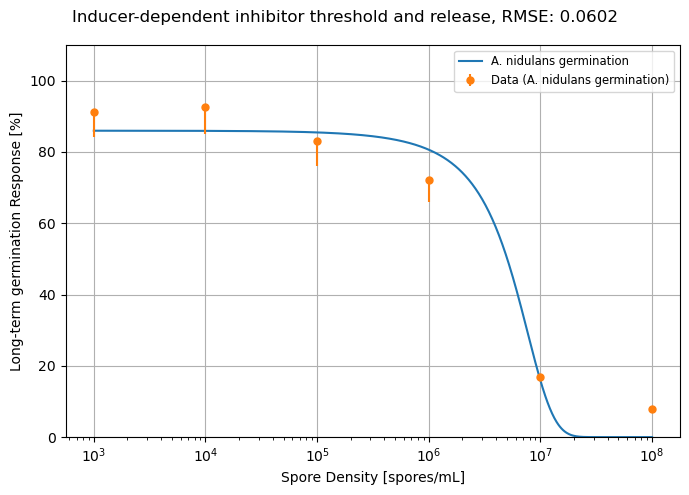

In [4]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_inhibitor.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(7, 5))
model_responses[1, :] .= germ_response_inducer_dep_inhibitor_combined_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, params_test[:μ_γ], params_test[:σ_γ]).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans germination"], yerr=errors.*100, ax=ax)
fig.suptitle("Inducer-dependent inhibitor threshold and release, RMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

### 4.2. Two-factor germination with inhibitor-dependent induction threshold

First, the parameters from the previous fitting round are tested.

0.07512131768834786


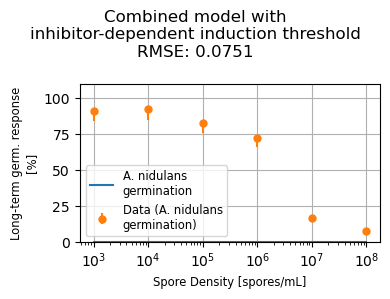

In [4]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inducer_thresh.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 3))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, def_params[:c₀_cs],
                                                                                params_test[:K_cs], params_test[:k],
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax)
fig.suptitle("Combined model with\ninhibitor-dependent induction threshold\nRMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

In [3]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_thresh", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_thresh.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1026 evals, 948 steps, improv/step: 0.590 (last = 0.5897), fitness=0.027043722
1.00 secs, 1646 evals, 1567 steps, improv/step: 0.486 (last = 0.3263), fitness=0.027043722
1.50 secs, 2069 evals, 1990 steps, improv/step: 0.442 (last = 0.2790), fitness=0.027043722
2.00 secs, 2561 evals, 2482 steps, improv/step: 0.398 (last = 0.2215), fitness=0.025121289
2.51 secs, 3087 evals, 3008 steps, improv/step: 0.362 (last = 0.1939), fitness=0.023190341
3.01 secs, 3580 evals, 3501 steps, improv/step: 0.339 (last = 0.1988), fitness=0.021809931
3.51 secs, 4071 evals, 3992 steps, improv/step: 0.325 (last = 0.2261), fi

Dict{Any, Any} with 8 entries:
  :σ_γ  => [4.18998e-5]
  :σ_ψ  => [0.0016178]
  :k    => [0.337989]
  :K_cs => [0.0179218]
  :μ_ω  => [0.0821026]
  :μ_γ  => [4.34731e-5]
  :μ_ψ  => [0.0216039]
  :σ_ω  => [0.000345924]

0.05541277136345128


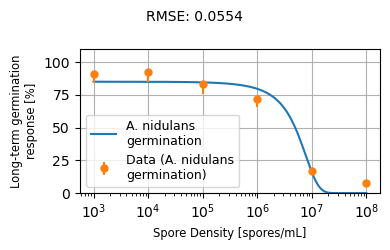

In [7]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_thresh.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, def_params[:c₀_cs],
                                                                                params_test[:K_cs], params_test[:k],
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 4.3. Two-factor germination with inhibitor-dependent induction signal

In [16]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_signal", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_signal.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 897 evals, 840 steps, improv/step: 0.561 (last = 0.5607), fitness=0.068240705
1.00 secs, 1381 evals, 1324 steps, improv/step: 0.487 (last = 0.3595), fitness=0.033766464
1.50 secs, 1834 evals, 1777 steps, improv/step: 0.419 (last = 0.2208), fitness=0.033766464
2.00 secs, 2297 evals, 2240 steps, improv/step: 0.377 (last = 0.2138), fitness=0.028906558
2.51 secs, 2714 evals, 2657 steps, improv/step: 0.343 (last = 0.1607), fitness=0.028027349
3.01 secs, 3085 evals, 3028 steps, improv/step: 0.315 (last = 0.1132), fitness=0.022768134
3.51 secs, 3474 evals, 3417 steps, improv/step: 0.293 (last = 0.1208), fit

Dict{Any, Any} with 9 entries:
  :σ_γ  => [4.09255e-5]
  :σ_ψ  => [0.0382063]
  :K_I  => [0.610595]
  :n    => [2.62106]
  :K_cs => [0.00495396]
  :μ_ω  => [0.134298]
  :μ_γ  => [4.41986e-5]
  :μ_ψ  => [0.403866]
  :σ_ω  => [0.00397778]

0.059838810383224146


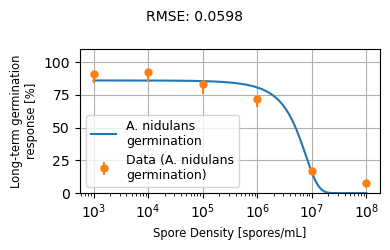

In [11]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_signal.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_signal_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, def_params[:c₀_cs],
                                                                                params_test[:K_cs], params_test[:K_I], params_test[:n],
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ]).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 4.3. Two-factor germination with inhibitor-dependent induction threshold and signal

In [18]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer", def_params, germ_responses, densities, bounds_narrow, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1107 evals, 1049 steps, improv/step: 0.565 (last = 0.5653), fitness=0.029164489
1.00 secs, 1622 evals, 1564 steps, improv/step: 0.483 (last = 0.3165), fitness=0.023632656
1.50 secs, 2103 evals, 2045 steps, improv/step: 0.441 (last = 0.3015), fitness=0.022515237
2.00 secs, 2541 evals, 2483 steps, improv/step: 0.404 (last = 0.2306), fitness=0.022515237
2.51 secs, 2969 evals, 2911 steps, improv/step: 0.380 (last = 0.2407), fitness=0.021834604
3.01 secs, 3342 evals, 3284 steps, improv/step: 0.366 (last = 0.2574), fitness=0.021777179
3.51 secs, 3776 evals, 3718 steps, improv/step: 0.354 (last = 0.2696), f

Dict{Any, Any} with 10 entries:
  :σ_γ  => [4.10104e-5]
  :σ_ψ  => [0.0512298]
  :K_I  => [0.00148811]
  :k    => [0.00345942]
  :K_cs => [0.00519026]
  :n    => [2.31034]
  :μ_ω  => [0.237194]
  :μ_γ  => [4.40853e-5]
  :μ_ψ  => [0.684141]
  :σ_ω  => [0.000155833]

0.05560252681206369


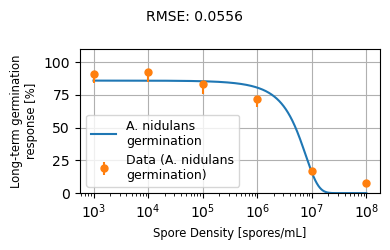

In [12]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_combined_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, def_params[:c₀_cs],
                                                                                params_test[:K_cs], params_test[:K_I], params_test[:k], params_test[:n],
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 4.5. Independent two-factor germination

In [7]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("independent", def_params, germ_responses, densities, bounds_broad, max_steps=max_steps)

jldopen("Data/fit2_independent.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 5 entries:
  :σ_γ  => [4.0995e-5]
  :K_cs => [0.0017491]
  :μ_ω  => [0.0199377]
  :μ_γ  => [4.41739e-5]
  :σ_ω  => [0.010036]

0.06023629838747336


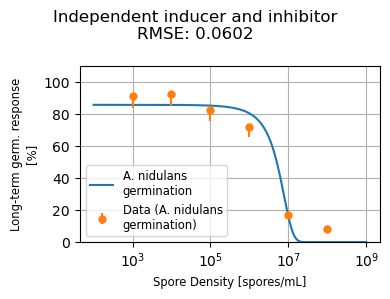

In [14]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_independent.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses), 2)
errors[1, :, 1] .= conf_intervals
germ_resp_vis = reshape(germ_responses, 1, length(germ_responses)).*100

# Generate test data
density_exp_range = LinRange(2, 9, 1000)
model_densities = 10 .^ density_exp_range
model_responses = zeros(1, length(model_densities))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 3))
model_responses[1, :] .= germ_response_independent_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                        params_test[:c₀_cs], params_test[:K_cs],
                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                        params_test[:μ_ω], params_test[:σ_ω]).*100
plot_germination_data_fit(densities, germ_resp_vis, model_densities, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax)
fig.suptitle("Independent inducer and inhibitor\nRMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

## 5. Fitting to exogenously driven inhibition data

As a next step, the models are fitted independently to the second data set, containing the germination response to exogenously added concentrations of 1-octen-3-ol. It is thereby observed whether the optimal parameters correspond to those fitted on the previous data.

### 5.1. Inducer-dependent inhibitor threshold and release

In [9]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("inhibitor_ex", def_params, germ_responses_ex, density_ex, bounds_broad, c_ex_vals=ex_concentrations, max_steps=max_steps)

jldopen("Data/fit2_inhibitor_ex.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 4 entries:
  :σ_γ => [0.00576673]
  :σ_ψ => [0.0659029]
  :μ_γ => [0.0131621]
  :μ_ψ => [0.177508]

0.025651125431937153


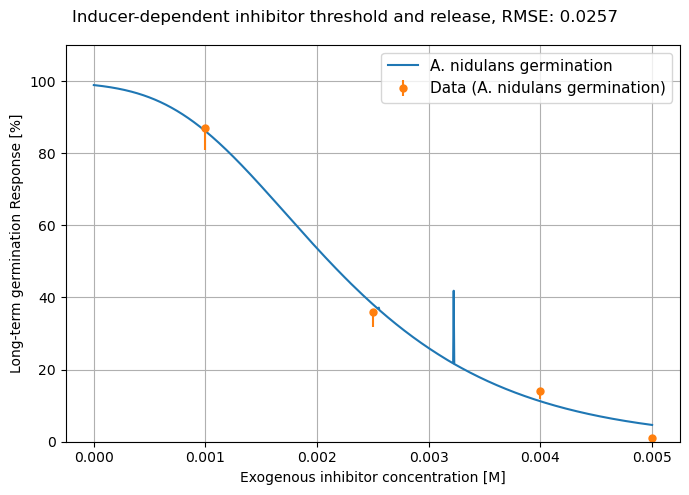

In [68]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_inhibitor_ex.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses_ex), 2)
errors[1, :, 1] .= conf_intervals_ex
germ_resp_vis = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses = zeros(1, length(model_concentrations))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(7, 5))
model_responses[1, :] .= germ_response_inducer_dep_inhibitor_combined_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-4).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis, model_concentrations, model_responses, ["A. nidulans germination"], yerr=errors.*100, ax=ax, c_ex=true)
fig.suptitle("Inducer-dependent inhibitor threshold and release, RMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

### 5.2. Two-factor germination with inhibitor-dependent induction threshold

In [9]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_thresh_ex", def_params, germ_responses_ex, density_ex, bounds_broad, c_ex_vals=ex_concentrations, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_thresh_ex.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction threshold (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1249 evals, 1188 steps, improv/step: 0.560 (last = 0.5598), fitness=0.534764785
1.00 secs, 1814 evals, 1753 steps, improv/step: 0.503 (last = 0.3823), fitness=0.426794735
1.50 secs, 2361 evals, 2300 steps, improv/step: 0.442 (last = 0.2468), fitness=0.110479456
2.01 secs, 2884 evals, 2823 steps, improv/step: 0.407 (last = 0.2524), fitness=0.011155736
2.51 secs, 3430 evals, 3369 steps, improv/step: 0.375 (last = 0.2143), fitness=0.011155736
3.01 secs, 3988 evals, 3927 steps, improv/step: 0.354 (last = 0.22

Dict{Any, Any} with 8 entries:
  :σ_γ  => [0.000122394]
  :σ_ψ  => [0.49611]
  :k    => [6.54636]
  :K_cs => [0.164525]
  :μ_ω  => [0.000899329]
  :μ_γ  => [0.00336452]
  :μ_ψ  => [0.725305]
  :σ_ω  => [0.000881318]

0.0033591628045707795


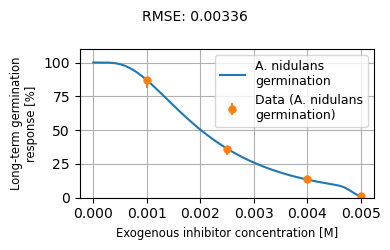

In [13]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_thresh_ex.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses_ex), 2)
errors[1, :, 1] .= conf_intervals_ex
germ_resp_vis = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses = zeros(1, length(model_concentrations))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:k],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis, model_concentrations, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax, c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 5.3. Two-factor germination with inhibitor-dependent induction signal

In [32]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_signal_ex", def_params, germ_responses_ex, density_ex, bounds_broad, c_ex_vals=ex_concentrations, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_signal_ex.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction signal (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1100 evals, 1033 steps, improv/step: 0.562 (last = 0.5624), fitness=0.433256538
1.00 secs, 1572 evals, 1505 steps, improv/step: 0.508 (last = 0.3877), fitness=0.355822883
1.50 secs, 2009 evals, 1942 steps, improv/step: 0.478 (last = 0.3753), fitness=0.239956456
2.00 secs, 2411 evals, 2344 steps, improv/step: 0.445 (last = 0.2861), fitness=0.036803912
2.51 secs, 2871 evals, 2804 steps, improv/step: 0.405 (last = 0.2000), fitness=0.013611150
3.01 secs, 3304 evals, 3237 steps, improv/step: 0.377 (last = 0.1986)

Dict{Any, Any} with 9 entries:
  :σ_γ  => [5.11192e-6]
  :σ_ψ  => [0.0351235]
  :K_I  => [0.0254423]
  :n    => [2.62021]
  :K_cs => [0.0316288]
  :μ_ω  => [0.0621357]
  :μ_γ  => [0.0403342]
  :μ_ψ  => [0.0631176]
  :σ_ω  => [0.0606717]

0.022399484610208357


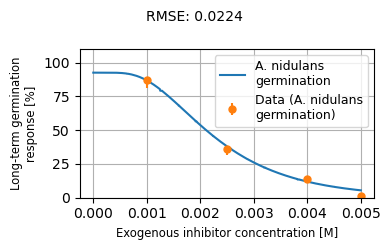

In [14]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_signal_ex.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses_ex), 2)
errors[1, :, 1] .= conf_intervals_ex
germ_resp_vis = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses = zeros(1, length(model_concentrations))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_signal_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-6, abstol=1e-8).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis, model_concentrations, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax, c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 5.4. Two-factor germination with inhibitor-dependent induction signal and threshold

In [38]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_ex", def_params, germ_responses_ex, density_ex, bounds_broad, c_ex_vals=ex_concentrations, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_ex.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction threshold and signal (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1031 evals, 944 steps, improv/step: 0.567 (last = 0.5667), fitness=0.468141987
1.00 secs, 1537 evals, 1450 steps, improv/step: 0.494 (last = 0.3577), fitness=0.262507216
1.50 secs, 2026 evals, 1939 steps, improv/step: 0.445 (last = 0.2986), fitness=0.171094649
2.00 secs, 2503 evals, 2416 steps, improv/step: 0.411 (last = 0.2767), fitness=0.136149999
2.51 secs, 2942 evals, 2855 steps, improv/step: 0.388 (last = 0.2574), fitness=0.030013944
3.01 secs, 3370 evals, 3283 steps, improv/step: 0.367 (l

Dict{Any, Any} with 10 entries:
  :σ_γ  => [7.33506e-6]
  :σ_ψ  => [0.0210552]
  :K_I  => [0.00404646]
  :k    => [1.41925]
  :K_cs => [0.316334]
  :n    => [1.69491]
  :μ_ω  => [0.000435281]
  :μ_γ  => [0.0780956]
  :μ_ψ  => [0.0310291]
  :σ_ω  => [0.000404601]

0.003542314314020863


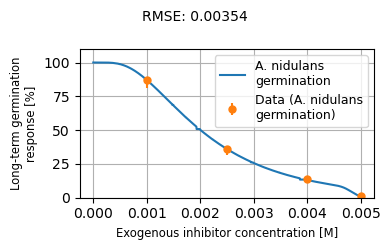

In [15]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_ex.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses_ex), 2)
errors[1, :, 1] .= conf_intervals_ex
germ_resp_vis = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses = zeros(1, length(model_concentrations))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 2.5))
model_responses[1, :] .= germ_response_inhibitor_dep_inducer_combined_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I],
                                                                                        params_test[:k], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-6, abstol=1e-8).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis, model_concentrations, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax, c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")

tight_layout()
gcf()

### 5.5. Independent two-factor germination

In [13]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("independent_ex", def_params, germ_responses_ex, density_ex, bounds_broad, c_ex_vals=ex_concentrations, max_steps=max_steps)

jldopen("Data/fit2_independent_ex.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 7 entries:
  :σ_γ  => [3.13981e-6]
  :σ_ψ  => [0.184779]
  :K_cs => [0.0321212]
  :μ_ω  => [0.0584576]
  :μ_γ  => [0.00757757]
  :μ_ψ  => [0.329322]
  :σ_ω  => [0.057469]

0.02290191940540583


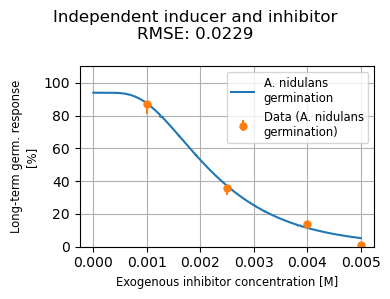

In [17]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_independent_ex.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors = zeros(1, length(germ_responses_ex), 2)
errors[1, :, 1] .= conf_intervals_ex
germ_resp_vis = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses = zeros(1, length(model_concentrations))

# Plot the fitted model against the germination data
fig, ax = subplots(figsize=(4, 3))
model_responses[1, :] .= germ_response_independent_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                            params_test[:c₀_cs], params_test[:K_cs],
                                                            params_test[:μ_γ], params_test[:σ_γ],
                                                            params_test[:μ_ω], params_test[:σ_ω],
                                                            params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis, model_concentrations, model_responses, ["A. nidulans\ngermination"], yerr=errors.*100, ax=ax, c_ex=true)
fig.suptitle("Independent inducer and inhibitor\nRMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

## 6. Parallel fitting to both data sets

Taking the two data sets separately, the models exhibit a good fit over the data, more so in the case of exogenously added inhibitor. To verify whether the germination responses from the two data sets share the same underlying mechanisms, the models are fitted on both data sets simultaneously.

### 6.1. Inducer-dependent inhibitor threshold and release

In [50]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("inhibitor_ex", def_params, vcat(germ_responses, germ_responses_ex), densities, bounds_narrow,
                                                c_ex_vals=ex_concentrations, ref_density=density_ex, max_steps=max_steps)

jldopen("Data/fit2_inhibitor_total.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Inducer-dependent inhibitor threshold and release
Model: Inducer-dependent inhibitor threshold and release (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 5681 evals, 5568 steps, improv/step: 0.392 (last = 0.3917), fitness=0.927578451

Optimization stopped after 10001 steps and 0.84 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 11849.53
Function evals per second = 11977.49
Improvements/step = 0.31160
Total function evaluations = 10109


Best candidate found: [4.42573e-5, -0.0750357, 0.999985, -0.0881081]

Fitness: 0.927569274

Running second optimisation stage
Final fitness: 0.9275692315012467
Converting δ = -0.07503704457723602 to σ scale
Converting δ = -

Dict{Any, Any} with 4 entries:
  :σ_γ => [4.10582e-5]
  :σ_ψ => [0.91566]
  :μ_γ => [4.42576e-5]
  :μ_ψ => [0.999997]

0.30456021268400224


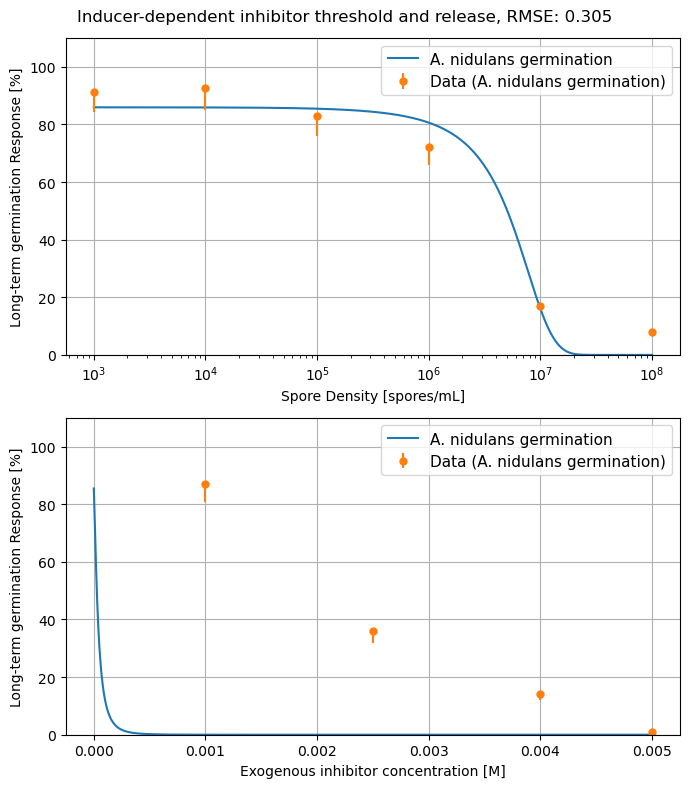

In [51]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_inhibitor_total.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors_dens = zeros(1, length(germ_responses), 2)
errors_dens[1, :, 1] .= conf_intervals
germ_resp_vis_dens = reshape(germ_responses, 1, length(germ_responses)).*100

errors_ex = zeros(1, length(germ_responses_ex), 2)
errors_ex[1, :, 1] .= conf_intervals_ex
germ_resp_vis_ex = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses_dens = zeros(1, length(model_densities))

model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses_ex = zeros(1, length(model_concentrations))


# Plot the fitted model against the germination data
fig, axs = subplots(2, 1, figsize=(7, 8))
model_responses_dens[1, :] .= germ_response_inducer_dep_inhibitor_combined_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ, params_test[:μ_γ], params_test[:σ_γ]).*100
plot_germination_data_fit(densities, germ_resp_vis_dens, model_densities, model_responses_dens, ["A. nidulans germination"], yerr=errors_dens.*100, ax=axs[1])

model_responses_ex[1, :] .= germ_response_inducer_dep_inhibitor_combined_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-4).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis_ex, model_concentrations, model_responses_ex, ["A. nidulans germination"], yerr=errors_ex.*100, ax=axs[2], c_ex=true)
fig.suptitle("Inducer-dependent inhibitor threshold and release, RMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

### 6.2. Two-factor germination with inhibitor-dependent induction threshold

In [52]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_thresh_ex", def_params, vcat(germ_responses, germ_responses_ex), densities, bounds_narrow,
                                                c_ex_vals=ex_concentrations, ref_density=density_ex, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_thresh_total.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction threshold (exogenous inhibitor)
Densities input: [1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6, 9.999999999999999e-6, 9.999999999999999e-5]
Reference density for exogenous inhibitor: 1.0e-7
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 932 evals, 870 steps, improv/step: 0.498 (last = 0.4977), fitness=0.953893717
1.00 secs, 1514 evals, 1452 steps, improv/step: 0.426 (last = 0.3179), fitness=0.943301909
1.50 secs, 2037 evals, 1975 steps, improv/step: 0.373 (last = 0.2275), fitness=0.932080665
2.00 secs, 2408 evals, 2346 steps, improv/step: 0.342 (last = 0.1752), fitness=0.931511721
2.50 secs, 2878

Dict{Any, Any} with 8 entries:
  :σ_γ  => [2.20175]
  :σ_ψ  => [0.890499]
  :k    => [53.7821]
  :K_cs => [0.0171577]
  :μ_ω  => [0.0653972]
  :μ_γ  => [9.99867e-5]
  :μ_ψ  => [0.994283]
  :σ_ω  => [0.0490895]

0.27676335421856985


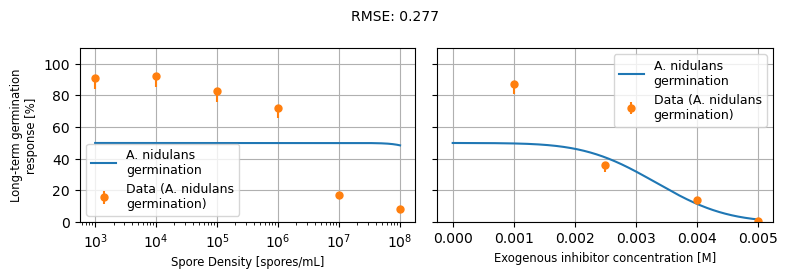

In [24]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_thresh_total.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors_dens = zeros(1, length(germ_responses), 2)
errors_dens[1, :, 1] .= conf_intervals
germ_resp_vis_dens = reshape(germ_responses, 1, length(germ_responses)).*100

errors_ex = zeros(1, length(germ_responses_ex), 2)
errors_ex[1, :, 1] .= conf_intervals_ex
germ_resp_vis_ex = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses_dens = zeros(1, length(model_densities))

model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses_ex = zeros(1, length(model_concentrations))


# Plot the fitted model against the germination data
fig, axs = subplots(1, 2, figsize=(8, 2.8), sharey=true)
model_responses_dens[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:k],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-6, abstol=1e-8).*100
plot_germination_data_fit(densities, germ_resp_vis_dens, model_densities, model_responses_dens, ["A. nidulans\ngermination"], yerr=errors_dens.*100, ax=axs[1])

model_responses_ex[1, :] .= germ_response_inhibitor_dep_inducer_thresh_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:k],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-5).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis_ex, model_concentrations, model_responses_ex, ["A. nidulans\ngermination"], yerr=errors_ex.*100, ax=axs[2], c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")
axs[2].set_ylabel(nothing)

tight_layout()
gcf()

### 6.3. Two-factor germination with inhibitor-dependent induction signal

In [42]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_signal_ex", def_params, vcat(germ_responses, germ_responses_ex), densities, bounds_narrow,
                                                c_ex_vals=ex_concentrations, ref_density=density_ex, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_signal_total.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction signal (exogenous inhibitor)
Densities input: [1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6, 9.999999999999999e-6, 9.999999999999999e-5]
Reference density for exogenous inhibitor: 1.0e-7
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1022 evals, 951 steps, improv/step: 0.595 (last = 0.5952), fitness=0.945634405
1.00 secs, 1595 evals, 1522 steps, improv/step: 0.523 (last = 0.4028), fitness=0.933115994
1.50 secs, 2059 evals, 1986 steps, improv/step: 0.459 (last = 0.2500), fitness=0.933115994
2.01 secs, 2487 evals, 2414 steps, improv/step: 0.422 (last = 0.2500), fitness=0.928073450
2.51 secs, 2863 e

Dict{Any, Any} with 9 entries:
  :σ_γ  => [4.15891e-5]
  :σ_ψ  => [0.972846]
  :K_I  => [0.670076]
  :n    => [2.14193]
  :K_cs => [0.0142359]
  :μ_ω  => [0.026618]
  :μ_γ  => [4.46982e-5]
  :μ_ψ  => [0.999992]
  :σ_ω  => [0.00352451]

0.30451828838260997


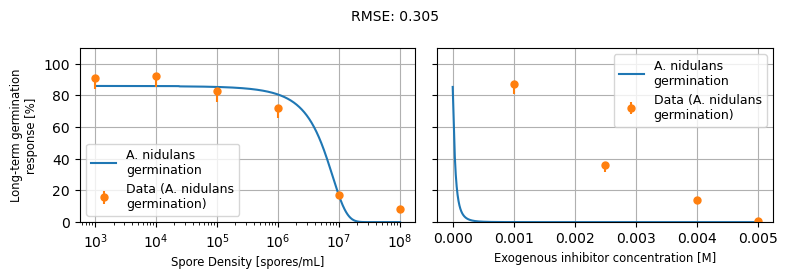

In [25]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_signal_total.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors_dens = zeros(1, length(germ_responses), 2)
errors_dens[1, :, 1] .= conf_intervals
germ_resp_vis_dens = reshape(germ_responses, 1, length(germ_responses)).*100

errors_ex = zeros(1, length(germ_responses_ex), 2)
errors_ex[1, :, 1] .= conf_intervals_ex
germ_resp_vis_ex = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses_dens = zeros(1, length(model_densities))

model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses_ex = zeros(1, length(model_concentrations))


# Plot the fitted model against the germination data
fig, axs = subplots(1, 2, figsize=(8, 2.8), sharey=true)
model_responses_dens[1, :] .= germ_response_inhibitor_dep_inducer_signal_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], abstol=1e-9).*100
plot_germination_data_fit(densities, germ_resp_vis_dens, model_densities, model_responses_dens, ["A. nidulans\ngermination"], yerr=errors_dens.*100, ax=axs[1])

model_responses_ex[1, :] .= germ_response_inhibitor_dep_inducer_signal_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-4).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis_ex, model_concentrations, model_responses_ex, ["A. nidulans\ngermination"], yerr=errors_ex.*100, ax=axs[2], c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")
axs[2].set_ylabel(nothing)

tight_layout()
gcf()

### 6.4. Two-factor germination with inhibitor-dependent induction threshold and signal

In [44]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("combined_inducer_ex", def_params, vcat(germ_responses, germ_responses_ex), densities, bounds_narrow,
                                                c_ex_vals=ex_concentrations, ref_density=density_ex, max_steps=max_steps)

jldopen("Data/fit2_combined_inducer_total.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Two-factor germination with inhibitor-dependent induction threshold
Model: Two-factor germination with inhibitor-dependent induction threshold and signal (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 863 evals, 794 steps, improv/step: 0.552 (last = 0.5516), fitness=0.951534240
1.01 secs, 1243 evals, 1174 steps, improv/step: 0.510 (last = 0.4237), fitness=0.943580384
1.51 secs, 1735 evals, 1666 steps, improv/step: 0.448 (last = 0.3008), fitness=0.943580384
2.01 secs, 2114 evals, 2045 steps, improv/step: 0.410 (last = 0.2427), fitness=0.943362326
2.51 secs, 2524 evals, 2455 steps, improv/step: 0.379 (last = 0.2220), fitness=0.938698121
3.01 secs, 2842 evals, 2773 steps, improv/step: 0.356 (la

Dict{Any, Any} with 10 entries:
  :σ_γ  => [2.15847]
  :σ_ψ  => [0.856422]
  :K_I  => [0.756588]
  :k    => [102.712]
  :K_cs => [0.00514018]
  :n    => [2.91618]
  :μ_ω  => [0.177113]
  :μ_γ  => [9.90005e-5]
  :μ_ψ  => [0.997924]
  :σ_ω  => [0.0937478]

0.2767619815365967


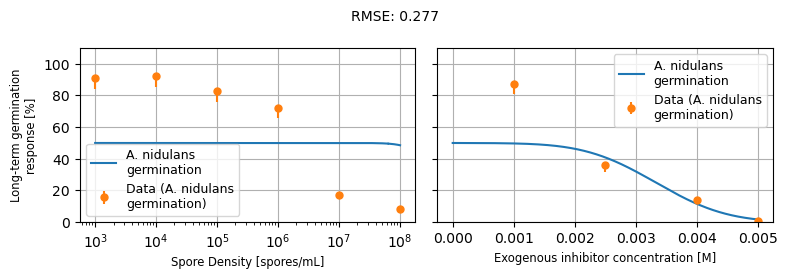

In [27]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_combined_inducer_total.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors_dens = zeros(1, length(germ_responses), 2)
errors_dens[1, :, 1] .= conf_intervals
germ_resp_vis_dens = reshape(germ_responses, 1, length(germ_responses)).*100

errors_ex = zeros(1, length(germ_responses_ex), 2)
errors_ex[1, :, 1] .= conf_intervals_ex
germ_resp_vis_ex = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses_dens = zeros(1, length(model_densities))

model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses_ex = zeros(1, length(model_concentrations))


# Plot the fitted model against the germination data
fig, axs = subplots(1, 2, figsize=(8, 2.8), sharey=true)
model_responses_dens[1, :] .= germ_response_inhibitor_dep_inducer_combined_2_factors_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I],
                                                                                        params_test[:k], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], abstol=1e-8).*100
plot_germination_data_fit(densities, germ_resp_vis_dens, model_densities, model_responses_dens, ["A. nidulans\ngermination"], yerr=errors_dens.*100, ax=axs[1])

model_responses_ex[1, :] .= germ_response_inhibitor_dep_inducer_combined_2_factors_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                                        params_test[:c₀_cs], params_test[:K_cs], params_test[:K_I],
                                                                                        params_test[:k], params_test[:n],
                                                                                        params_test[:μ_γ], params_test[:σ_γ],
                                                                                        params_test[:μ_ω], params_test[:σ_ω],
                                                                                        params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-4).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis_ex, model_concentrations, model_responses_ex, ["A. nidulans\ngermination"], yerr=errors_ex.*100, ax=axs[2], c_ex=true)
fig.suptitle("RMSE: $(round(rmse, sigdigits=3))", fontsize="medium")
axs[2].set_ylabel(nothing)

tight_layout()
gcf()

### 6.5. Independent two-factor germination

In [46]:
max_steps = 10000
params_opt, rmse = fit_model_to_data_equilibrium("independent_ex", def_params, vcat(germ_responses, germ_responses_ex), densities, bounds_narrow,
                                                c_ex_vals=ex_concentrations, ref_density=density_ex, max_steps=max_steps)

jldopen("Data/fit2_independent_total.jld2", "w") do file
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: Independent factors
Model: Independent factors (exogenous inhibitor)
Running first optimisation stage
Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 5976 evals, 5909 steps, improv/step: 0.324 (last = 0.3239), fitness=0.927630517

Optimization stopped after 10001 steps and 0.88 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 11429.71
Function evals per second = 11505.14
Improvements/step = 0.34690
Total function evaluations = 10067


Best candidate found: [0.0236315, 4.43266e-5, -0.0746381, 0.026864, -9.17609, 1.0, -1.01362e-7]

Fitness: 0.927595234

Running second optimisation stage
Final fitness: 0.9275952335830904
Converting δ = -0.0746187809217469 to σ scale
Converting δ = -9.176210891080428 to σ scale
Conve

Dict{Any, Any} with 7 entries:
  :σ_γ  => [4.11403e-5]
  :σ_ψ  => [1.0]
  :K_cs => [0.0270918]
  :μ_ω  => [0.0268797]
  :μ_γ  => [4.43275e-5]
  :μ_ψ  => [1.0]
  :σ_ω  => [2.78129e-6]

0.3045644814457343


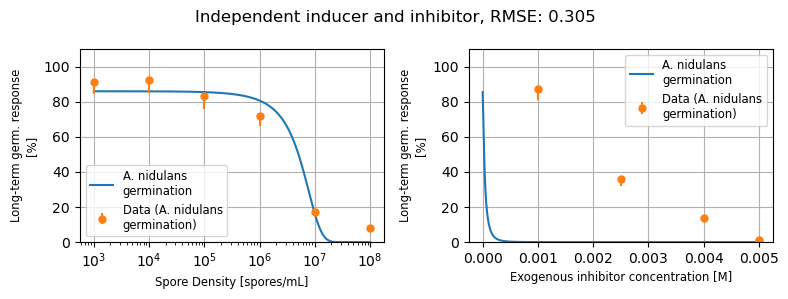

In [22]:
matplotlib.pyplot.close()

# Load the fitted parameters
def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit2_independent_total.jld2", "r") do file
    return file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)
for (key, value) in params_test
    params_test[key] = value[1]
end

# Reshape inputs
errors_dens = zeros(1, length(germ_responses), 2)
errors_dens[1, :, 1] .= conf_intervals
germ_resp_vis_dens = reshape(germ_responses, 1, length(germ_responses)).*100

errors_ex = zeros(1, length(germ_responses_ex), 2)
errors_ex[1, :, 1] .= conf_intervals_ex
germ_resp_vis_ex = reshape(germ_responses_ex, 1, length(germ_responses_ex)).*100

# Generate test data
density_exp_range = LinRange(3, 8, 1000)
model_densities = 10 .^ density_exp_range
model_responses_dens = zeros(1, length(model_densities))

model_concentrations = LinRange(0.0, ex_concentrations[end], 1000)
model_responses_ex = zeros(1, length(model_concentrations))


# Plot the fitted model against the germination data
fig, axs = subplots(1, 2, figsize=(8, 3))
model_responses_dens[1, :] .= germ_response_independent_eq.(inverse_mL_to_cubic_um.(model_densities), dist_ξ,
                                                            params_test[:c₀_cs], params_test[:K_cs],
                                                            params_test[:μ_γ], params_test[:σ_γ],
                                                            params_test[:μ_ω], params_test[:σ_ω]).*100
plot_germination_data_fit(densities, germ_resp_vis_dens, model_densities, model_responses_dens, ["A. nidulans\ngermination"], yerr=errors_dens.*100, ax=axs[1])

model_responses_ex[1, :] .= germ_response_independent_eq_c_ex.(inverse_mL_to_cubic_um(density_ex), dist_ξ, model_concentrations,
                                                                params_test[:c₀_cs], params_test[:K_cs],
                                                                params_test[:μ_γ], params_test[:σ_γ],
                                                                params_test[:μ_ω], params_test[:σ_ω],
                                                                params_test[:μ_ψ], params_test[:σ_ψ], reltol=1e-4).*100
plot_germination_data_fit(ex_concentrations, germ_resp_vis_ex, model_concentrations, model_responses_ex, ["A. nidulans\ngermination"], yerr=errors_ex.*100, ax=axs[2], c_ex=true)
fig.suptitle("Independent inducer and inhibitor, RMSE: $(round(rmse, sigdigits=3))")

tight_layout()
gcf()

## 7. Final compilation of the results

The fitted parameters and RMSE values from all experiments presented so far are compiled in a $\LaTeX$ table.

In [19]:
println(summarise_fitted_parameters("A_nidulans_fitting", model_types=["combined_inducer_thresh", "combined_inducer_signal", "combined_inducer"], extra_tags=["total"]))

Processing model: combined_inducer
Processing model: combined_inducer_signal
Processing model: combined_inducer_signal
Processing model: combined_inducer_thresh
Processing model: combined_inducer_thresh
Processing model: combined_inducer
\begin{tabular}{p{2cm}p{3.5cm}p{3.5cm}p{3.5cm}p{1.5cm}}
\toprule
$\textbf{Parameter}$ & Model: \newline$\textbf{2 factors,}\newline \textbf{inhibitor →  }\newline \textbf{inducer}\newline \textbf{threshold}$ & Model: \newline$\textbf{2 factors,}\newline \textbf{inhibitor →  }\newline \textbf{inducer}\newline \textbf{signal}$ & Model: \newline$\textbf{2 factors,}\newline \textbf{inhibitor →  }\newline \textbf{inducer}\newline \textbf{thresh. + signal}$ & $\textbf{Units}$ \\
\midrule
$k$ & $\num{5.3782e+01}$ & $ $ & $\num{1.0271e+02}$ & $-$ \\
\midrule
$K_I$ & $ $ & $\num{6.7008e-01}$ & $\num{7.5659e-01}$ & $\si{M}$ \\
\midrule
$K_{\textrm{cs}}$ & $\num{1.7158e-02}$ & $\num{1.4236e-02}$ & $\num{5.1402e-03}$ & $\si{M}$ \\
\midrule
$n$ & $ $ & $\num{2.1419

## References

- [1] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.
- [2] Ijadpanahsaravi, M., Teertstra, W.R., & Wösten, H.A. (2022). Inter- and intra-species heterogeneity in germination of Aspergillus conidia. Antonie Van Leeuwenhoek, 115, 1151 - 1164.
- [3] Yu, J. (2010). Regulation of Development in Aspergillus nidulans and Aspergillus fumigatus. Mycobiology, 38, 229 - 237.
- [4] Pontecorvo, G., Roper, J.A., Chemmons, L.M., Macdonald, K.D., & Bufton, A. (1953). The genetics of Aspergillus nidulans. Advances in genetics, 5, 141-238 .